In [1]:
import standard_hopfield as sh
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, njit
import time
import math
from scipy import optimize
from scipy.optimize import curve_fit, fsolve
from scipy import stats

We define the critical probability as
$$
p_c(N, \alpha) := \left\{p: \mathbb{P}^{reconst}_{N, \alpha}(p) = \frac{1}{2} \right\},
$$
that is, the corruption probability such that the reconstruction probability is equal to 0.5. <br>
Thus, taking the $\lim_{N \to \infty}$, we define:
$$
p_c(\alpha) = \lim_{N \to \infty} p_c(N, \alpha).
$$
Assuming that $ p_c(N, \alpha) \sim 1/N $, i.e.
$$
p_c(N, \alpha) = p_c(\alpha) + \frac{1}{N} p_c(\alpha) + o\left(\frac{1}{N^2}\right)
$$
**our goal is to determine $p_c(\alpha)$**.<br>
In order to achieve this, we need to fit the $\mathbb{P}^{reconst}_{N, \alpha}(p)$ function:
$$
\mathbb{P}^{reconst}_{N, \alpha}(p) = exp[{a_{N, \alpha}p + b_{N, \alpha} p^2 + c_{N, \alpha} p^3}]
$$

## $p_c$ for $\alpha$ = 0.1

In [6]:
#load the data
N = np.array([100, 200, 300, 400, 500, 600,700, 800, 900, 1000])#, 500, 1000, 2000])
pp = np.linspace(0.05, 0.6, 25)
P_100 = np.loadtxt("julia_data/alpha_01/probsN100.txt", delimiter = "\t")[:, 0]
P_200 = np.loadtxt("julia_data/alpha_01/probsN200.txt", delimiter = "\t")[:, 0]
P_300 = np.loadtxt("julia_data/alpha_01/probsN300.txt", delimiter = "\t")[:, 0]
P_400 = np.loadtxt("julia_data/alpha_01/probsN400.txt", delimiter = "\t")[:, 0]
P_500 = np.loadtxt("julia_data/alpha_01/probsN500.txt", delimiter = "\t")[:, 0]
P_600 = np.loadtxt("julia_data/alpha_01/probsN600.txt", delimiter = "\t")[:, 0]
P_700 = np.loadtxt("julia_data/alpha_01/probsN700.txt", delimiter = "\t")[:, 0]
P_800 = np.loadtxt("julia_data/alpha_01/probsN800.txt", delimiter = "\t")[:, 0]
P_900 = np.loadtxt("julia_data/alpha_01/probsN900.txt", delimiter = "\t")[:, 0]
P_1000 = np.loadtxt("julia_data/alpha_01/probsN1000.txt", delimiter = "\t")[:, 0]
#P_1000 = np.loadtxt("julia_data/alpha_01/probsN1000.txt", delimiter = "\t")[:, 0]
#P_2000 = np.loadtxt("julia_data/alpha_01/probsN2000.txt", delimiter = "\t")[:, 0]


In [8]:
P_200

array([0.93      , 0.93333333, 0.92866667, 0.91733333, 0.89933333,
       0.886     , 0.87533333, 0.84733333, 0.812     , 0.71466667,
       0.64066667, 0.53933333, 0.422     , 0.31866667, 0.19133333,
       0.11666667, 0.058     , 0.022     , 0.00466667, 0.00266667,
       0.00133333, 0.002     , 0.        , 0.        , 0.        ])

In [12]:
# fit the probability of reconstruction
def P_rec(p, a, b, c): return np.exp(a * p + b * p**2 + c * p**3)
P = [P_100, P_200, P_300, P_400, P_500, P_600, P_700, P_800, P_900, P_1000]#, P_500, P_1000, P_2000]
p_critical = np.zeros(len(P))

for i in range(len(P)):
    popt, pcov = curve_fit(P_rec, pp, P[i])
    sol = optimize.root_scalar(lambda p: np.exp(popt[0] * p + popt[1] * p**2 + popt[2] * p**3) - 0.5,
                           x0 = 0.60, bracket = [0.1, 7], method='brentq')
    p_critical[i] = sol.root
    #f = lambda p: np.exp(popt[0] * p + popt[1] * p**2 + popt[2] * p**3) - 0.5
    #sol = fsolve(f, 0.31)
    #p_critical[i] = sol
    #root = optimize.newton(lambda p: np.exp(popt[0] * p + popt[1] * p**2 + popt[2] * p**3) - 2, 0.5)
    #p_critical[i] = root

In [13]:
p_critical = p_critical[::-1] # reverse the array since we want to plot against 1/N

In [14]:
N_reciproc = np.array(list(map(lambda n: 1/n, N)))[::-1]

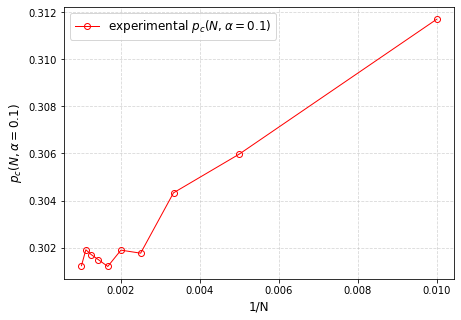

In [16]:
N_reciproc.reshape(-1,1)
res = stats.linregress(N_reciproc, p_critical)
intercept = res.intercept
slope = res.slope

size = 12
fig = plt.figure(figsize = (7,5))
plt.plot(N_reciproc, p_critical, c = "red", marker = "o", markerfacecolor = "None",
         linewidth = 1., label = r"experimental $p_c(N, \alpha = 0.1)$")
#plt.plot(N_reciproc, intercept + slope * N_reciproc, linestyle = "--", c = "black",
#         linewidth = 1., label = r"regression line $p_c(\alpha = 0.1)$ = {}".format(round(intercept, 3)))
plt.xlabel(r"1/N", size = size)
plt.ylabel(r"$p_c(N, \alpha = 0.1)$", size = size)
plt.grid(axis = "both", linestyle = "--", alpha = 0.5)
plt.legend(fontsize = size)
plt.show()
#fig.savefig("images/p_c_α01.pdf", transparent = True)

%%time
N = np.array([250])
parameters = {
    "pp": np.linspace(0.02, 0.6, 25),
    "α": 0.1,
    "nsweeps": 70,
    "ntrials": 1,
    "nsamples": 2000,
    "β": 10**3,
    "earlystop": 0,
    "plot": True,
    "save": False
}

for n in N:
    print("Starting simulation for N = {}".format(n), "\n...")
    p, e = reconstruction_probability(n, **parameters)
    print("Done!\n\n")